In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn as sk
import os 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(style='ggplot')

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# For regression analysis we will use the statsmodels package
import statsmodels.formula.api as smf

# For visual inspection of the regression models
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

import pycountry_convert as pc

In [2]:
df = pd.read_csv('master.csv')

In [3]:
#Get continent for each country
def country_to_continent(country_name):
    country_code = pc.country_name_to_country_alpha2(country_name)
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name

#To obtain the continent some countries needed to be renamed
df["country"] = df["country"].replace({"Republic of Korea":"Korea, Republic of"})
df["country"] = df["country"].replace({"Saint Vincent and Grenadines":"Saint Vincent and the Grenadines"})

#Add continent to the dataset
df["continent"] = df.apply(lambda x: country_to_continent(x["country"]), axis = 1)

df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,continent
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X,Europe
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent,Europe
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X,Europe
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation,Europe
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers,Europe


In [4]:
#Update the column headings
df.rename(columns={"suicides/100k pop":"suicides_100k_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)

#dropping HDI for year and country-year column for the analysis objectives.
df.drop(columns=["country-year", "HDI_for_year"], inplace=True)

df

,country,year,sex,age,suicides_no,population,suicides_100k_pop,gdp_for_year,gdp_per_capita,generation,continent
0,Albania,1987,male,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X,Europe
1,Albania,1987,male,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent,Europe
2,Albania,1987,female,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X,Europe
3,Albania,1987,male,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation,Europe
4,Albania,1987,male,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers,Europe
...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,"63,067,077,179",2309,Generation X,Asia
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,"63,067,077,179",2309,Silent,Asia
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,"63,067,077,179",2309,Generation Z,Asia
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,"63,067,077,179",2309,Generation Z,Asia


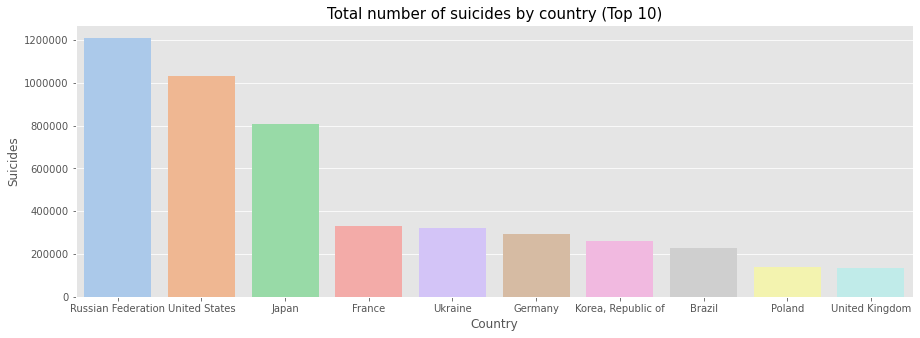

In [5]:
#Grouping the data by country
gp_cnt_data = df.groupby('country', as_index=False).sum()
top_ten = gp_cnt_data.nlargest(10, 'suicides_no').sort_values('suicides_no', ascending=False)

#Plotting the number of suicides according to the countries 
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(y='suicides_no', x='country', palette='pastel', data=top_ten, ax=ax)
plt.ylabel('Suicides')
plt.xlabel('Country')
plt.title('Total number of suicides by country (Top 10)', size=15)
ax.ticklabel_format(style='plain', axis='y')
plt.show()

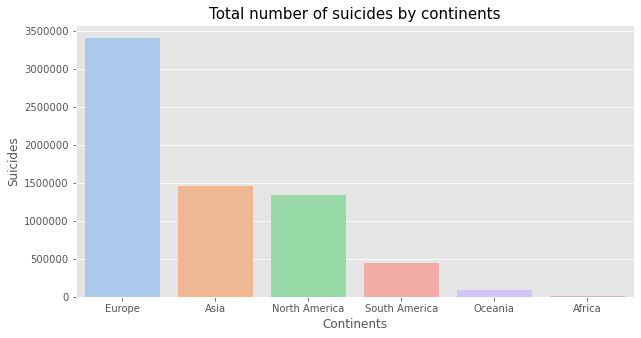

In [6]:
#Grouping the data by continent
gp_con_data = df.groupby('continent', as_index=False).sum()
top_ten_con = gp_con_data.nlargest(10, 'suicides_no').sort_values('suicides_no', ascending=False)

#Plotting the number of suicides according to the continent 
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y='suicides_no', x='continent', palette='pastel', data=top_ten_con, ax=ax)
plt.ylabel('Suicides')
plt.xlabel('Continents')
plt.title('Total number of suicides by continents', size=15)
ax.ticklabel_format(style='plain', axis='y')
plt.show()

Text(0, 0.5, 'Suicides per 100k')

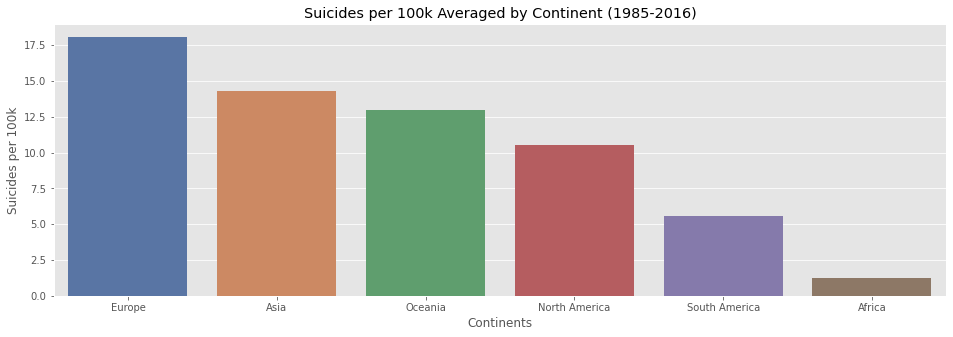

In [7]:
#Plotting the averaged suicides per 100k by continents
cont_pop = df.groupby("continent")["population"].sum()
cont_raw = df.groupby("continent")["suicides_no"].sum()
cont_rate = ((cont_raw / cont_pop) * 100000).to_frame()
cont_rate = cont_rate.rename(columns = {0: "Average_Rate"})
cont_rate = cont_rate.sort_values(by = "Average_Rate", ascending = False)

cont_year_pop = df.groupby(["continent", "year"])["population"].sum()
cont_year_raw = df.groupby(["continent", "year"])["suicides_no"].sum()
cont_year_rate = ((cont_year_raw / cont_year_pop) * 100000).to_frame().reset_index()
cont_year_rate = cont_year_rate.rename(columns = {0: "Average_Rate"})

average = cont_rate["Average_Rate"].mean()

fig, ax1 = plt.subplots(figsize=(16,5))
ax1.set_title("Suicides per 100k Averaged by Continent (1985-2016)")

sns.barplot(ax = ax1, data = cont_rate, x = cont_rate.index, y = cont_rate["Average_Rate"], palette='deep')
ax1.set_xlabel("Continents")
ax1.set_ylabel("Suicides per 100k")
#ax1.axvline(x = average, c = "black")

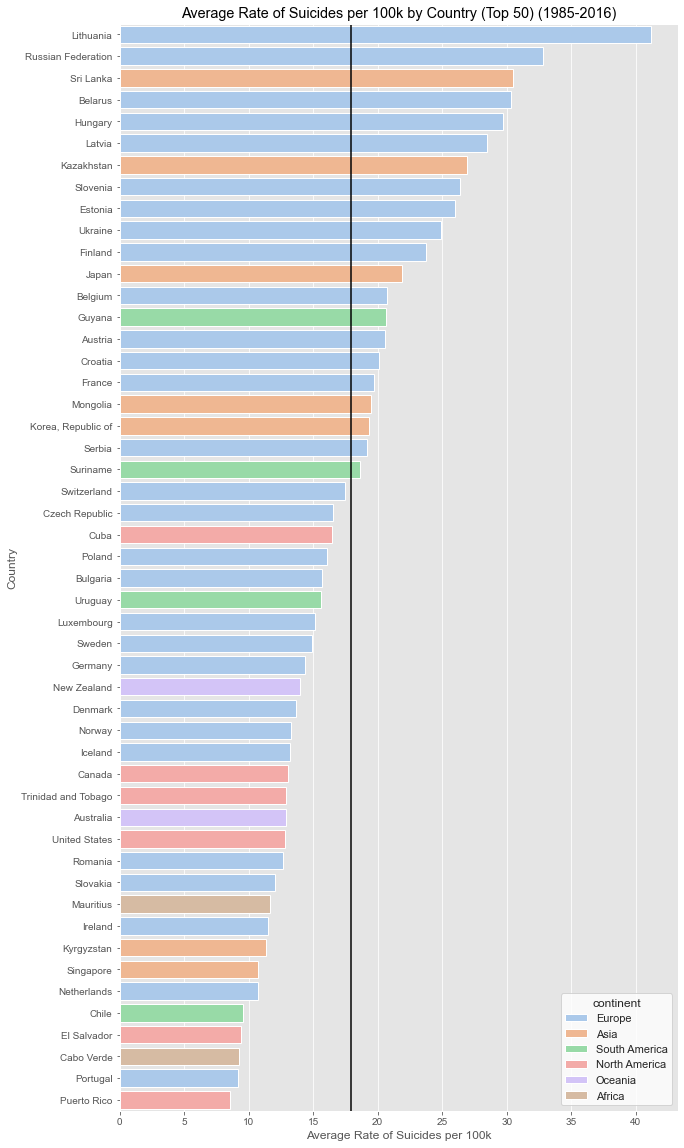

In [8]:
#Plotting the average rate of suicides per 100k by Country with continents
country_pops = df.groupby(["country", "continent"])["population"].sum()
country_raw = df.groupby(["country", "continent"])["suicides_no"].sum()

country_rate = ((country_raw / country_pops) * 100000).to_frame().reset_index()
country_rate = country_rate.rename(columns = {0:"rate"})
country_rate = country_rate.nlargest(50, 'rate').sort_values(by = "rate", ascending = False)

average = country_rate["rate"].mean()

plt.figure(figsize = (10,20))
plt.title("Average Rate of Suicides per 100k by Country (Top 50) (1985-2016)")
sns.set(style = "whitegrid")

sns.barplot(data = country_rate, y = "country", x = country_rate["rate"], hue = "continent", dodge = False, palette ='pastel')
plt.axvline(x = average, c = "black")
plt.xlabel('Average Rate of Suicides per 100k')
plt.ylabel('Country')
plt.show()

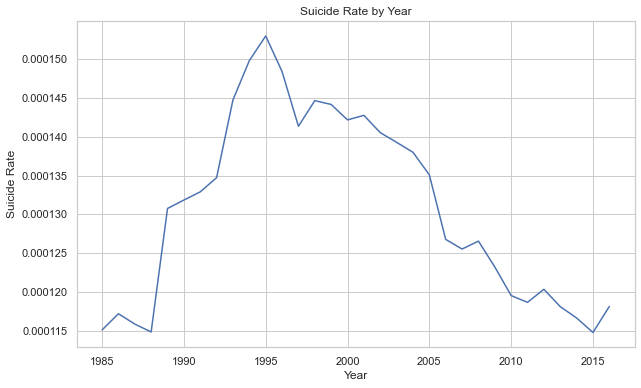

In [9]:
df_year_country = df[['country','year','sex','suicides_no', 'population']]
df_year = df_year_country.groupby(by='year').sum()
df_year['suicide_rate'] = df_year['suicides_no']/df_year['population']

plt.figure(figsize=(10,6))
sns.lineplot(data=df_year, x=df_year.index, y="suicide_rate")
plt.xlabel('Year')
plt.ylabel('Suicide Rate')
plt.title('Suicide Rate by Year')
#plt.legend()
plt.show()

In [10]:
# Calculate suicide rate autocorrelation 
# using the lags ranging from 1 to 31 years
max_lag=31
sui_rate_ac = [df_year['suicide_rate'].autocorr(lag=i) for i in range(max_lag)]

Text(0, 0.5, 'Autocorrelation')

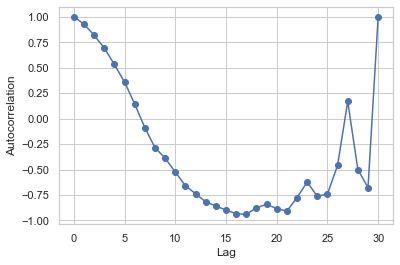

In [11]:
# Plot the results
plt.plot(range(max_lag), sui_rate_ac, 'o-')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

Text(0.5, 1.0, 'An Autocorrelation Graph of Suicide Rate')

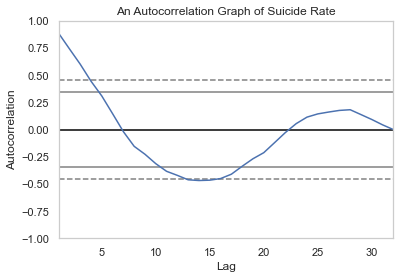

In [12]:
sui_yr_ac_plot = pd.plotting.autocorrelation_plot(df_year['suicide_rate'])
sui_yr_ac_plot.set_title('An Autocorrelation Graph of Suicide Rate')

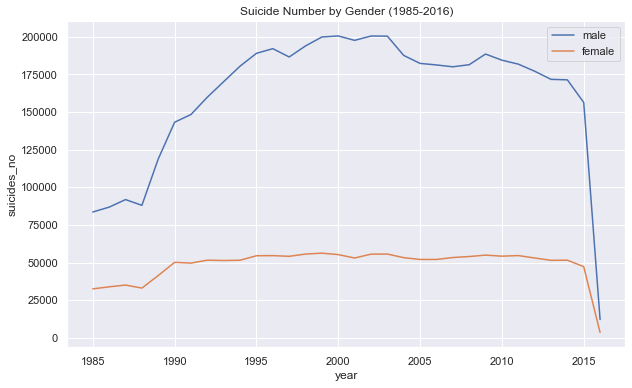

In [13]:
# The follow code is for analysing suicide number and suicide rate by year
# plot suicide number by gender by year
df_men = df[df.sex == "male"]
df_men = df_men.groupby(by='year').sum()

df_women = df[df.sex == "female"]
df_women = df_women.groupby(by='year').sum()

sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(df_men.index, df_men.suicides_no, ci = None)
sns.lineplot(df_women.index, df_women.suicides_no, ci = None)
plt.title('Suicide Number by Gender (1985-2016)')
plt.legend(["male", 'female'])
plt.show()

In [14]:
# calculate suicide rate by gender by year
df_year_sex = df_year_country[['year','country','sex','suicides_no','population']]
df_year_sex['suicide_rate']=df_year_sex['suicides_no']/df_year_sex['population']
df_year_sex

,year,country,sex,suicides_no,population,suicide_rate
0,1987,Albania,male,21,312900,0.000067
1,1987,Albania,male,16,308000,0.000052
2,1987,Albania,female,14,289700,0.000048
3,1987,Albania,male,1,21800,0.000046
4,1987,Albania,male,9,274300,0.000033
...,...,...,...,...,...,...
27815,2014,Uzbekistan,female,107,3620833,0.000030
27816,2014,Uzbekistan,female,9,348465,0.000026
27817,2014,Uzbekistan,male,60,2762158,0.000022
27818,2014,Uzbekistan,female,44,2631600,0.000017


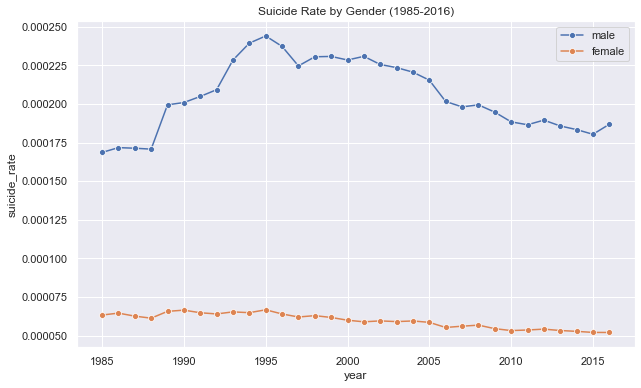

In [15]:
# Calculating the suicide rate by gender by year in the world

df_men['suicide_rate']=df_men['suicides_no']/df_men['population']
df_women['suicide_rate']=df_women['suicides_no']/df_women['population']

sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(df_men.index, df_men.suicide_rate,marker='o', ci = None)
sns.lineplot(df_women.index, df_women.suicide_rate,marker='o', ci = None)
plt.title('Suicide Rate by Gender (1985-2016)')
plt.legend(["male", 'female'])
plt.show()

In [16]:
# The code lines below are for analyzing suicide rate by Country and Year:
df_country = df_year_country.groupby(['country']).sum().drop(columns='year')
df_country['sui_rate_country'] = df_country['suicides_no']/df_country['population']
df_country.sort_values(by=['sui_rate_country'], inplace =True, ascending=False)
df_country.describe()

,suicides_no,population,sui_rate_country
count,1.010000e+02,1.010000e+02,101.000000
mean,6.681604e+04,5.081402e+08,0.000110
std,1.821609e+05,1.122953e+09,0.000087
min,0.000000e+00,6.640000e+04,0.000000
25%,5.850000e+02,1.295316e+07,0.000040
50%,1.129400e+04,1.117903e+08,0.000082
75%,5.007300e+04,3.775139e+08,0.000157
max,1.209742e+06,8.054027e+09,0.000412


In [17]:
df_country=df_country.reset_index()
df_country

,country,suicides_no,population,sui_rate_country
0,Lithuania,28039,68085210,0.000412
1,Russian Federation,1209742,3690802620,0.000328
2,Sri Lanka,55641,182525626,0.000305
3,Belarus,59892,197372292,0.000303
4,Hungary,73891,248644256,0.000297
...,...,...,...,...
96,Antigua and Barbuda,11,1990228,0.000006
97,Jamaica,184,39481817,0.000005
98,Oman,33,8987087,0.000004
99,Dominica,0,66400,0.000000


In [18]:
# get country list of top 10 suicide rate
country_list =df_country['country'][:10].tolist()
country_list

['Lithuania',
 'Russian Federation',
 'Sri Lanka',
 'Belarus',
 'Hungary',
 'Latvia',
 'Kazakhstan',
 'Slovenia',
 'Estonia',
 'Ukraine']

In [19]:
# inner join dataframes on the key: country
# the purpose is to sort suicide rate by country (top 10), in which analyzing suicide rate by year 
df_join = pd.merge(df_year_country,df_country,on='country')
df_join = df_join.sort_values(by='sui_rate_country', ascending = False)

# Calculating suicide rate by year for each country
df_join['sui_rate_yr'] = df_join['suicides_no_x']/df_join['population_x']
df_join

,country,year,sex,suicides_no_x,population_x,suicides_no_y,population_y,sui_rate_country,sui_rate_yr
15081,Lithuania,1998,male,345,278617,28039,68085210,0.000412,0.001238
15142,Lithuania,2003,male,53,57169,28039,68085210,0.000412,0.000927
15140,Lithuania,2003,male,529,458658,28039,68085210,0.000412,0.001153
15139,Lithuania,2002,female,1,230997,28039,68085210,0.000412,0.000004
15138,Lithuania,2002,male,4,240849,28039,68085210,0.000412,0.000017
...,...,...,...,...,...,...,...,...,...
21265,Saint Kitts and Nevis,1990,female,0,1000,0,117300,0.000000,0.000000
21266,Saint Kitts and Nevis,1990,male,0,4900,0,117300,0.000000,0.000000
21267,Saint Kitts and Nevis,1990,male,0,2400,0,117300,0.000000,0.000000
21268,Saint Kitts and Nevis,1990,male,0,2400,0,117300,0.000000,0.000000


In [20]:
df_top10 = df_join[df_join['country'].isin(country_list)]
df_top10 = df_top10[['country', 'year','sui_rate_yr']]
df_top10

,country,year,sui_rate_yr
15081,Lithuania,1998,0.001238
15142,Lithuania,2003,0.000927
15140,Lithuania,2003,0.001153
15139,Lithuania,2002,0.000004
15138,Lithuania,2002,0.000017
...,...,...,...
26237,Ukraine,2001,0.000706
26238,Ukraine,2001,0.000698
26239,Ukraine,2001,0.000470
26240,Ukraine,2001,0.000286


Text(0.5, 1.0, 'Top 10 Suicide Rate in Countries by Year')

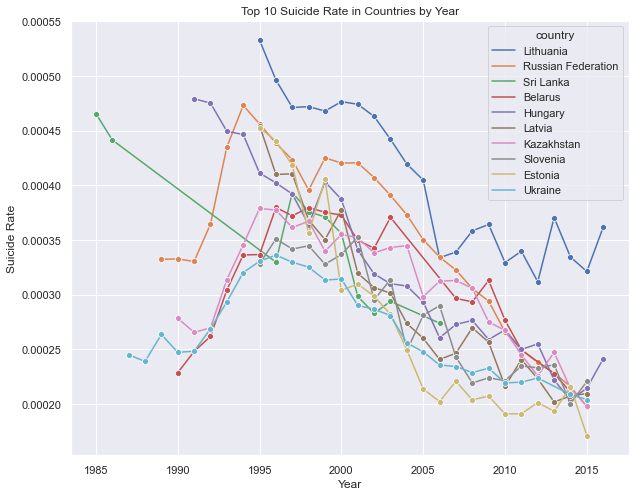

In [21]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=df_top10, x="year", y="sui_rate_yr", hue="country", marker="o", ci=None)

plt.xlabel("Year")
plt.ylabel("Suicide Rate")
plt.title('Top 10 Suicide Rate in Countries by Year')

In [22]:
# another way to get the lineplot as above:

df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum
df_total.head(10)

country  year
Albania  1987    0.002694
         1988    0.002279
         1989    0.002426
         1992    0.001665
         1993    0.002600
         1994    0.001755
         1995    0.003031
         1996    0.003027
         1997    0.005710
         1998    0.005112
dtype: float64

In [23]:
country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

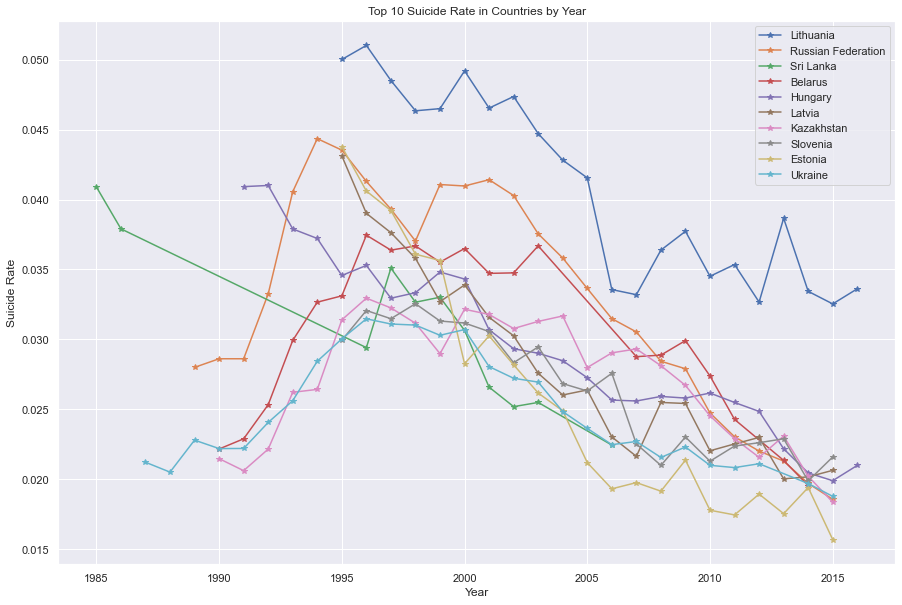

In [24]:
plt.figure(figsize = (15,10))
for country in country_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="*")
plt.xlabel("Year")
plt.ylabel("Suicide Rate")
plt.title('Top 10 Suicide Rate in Countries by Year')
plt.legend()
plt.show()

In [25]:
# The following code is for North America
# exatract data from joined dataframe for United States, Canada and Mexico
df_yr_ctr_na=df_join[df_year_country['country'].isin (['United States','Canada','Mexico'])]

In [26]:
df_yr_ctr_na.describe()

,year,suicides_no_x,population_x,suicides_no_y,population_y,sui_rate_country,sui_rate_yr
count,1092.000000,1092.000000,1.092000e+03,1.092000e+03,1.092000e+03,1092.000000,1.092000e+03
mean,1999.681319,1147.173077,1.067128e+07,4.243844e+05,3.951561e+09,0.000099,1.028463e-04
std,8.780713,2007.449580,1.013635e+07,4.384013e+05,3.054221e+09,0.000042,1.074200e-04
min,1985.000000,4.000000,3.902000e+05,1.075610e+05,8.260522e+08,0.000040,9.824148e-07
25%,1992.000000,99.500000,2.287557e+06,1.075610e+05,8.260522e+08,0.000040,1.346825e-05
50%,2000.000000,360.000000,7.826969e+06,1.111390e+05,2.772959e+09,0.000128,6.159105e-05
75%,2007.000000,1038.500000,1.835185e+07,1.034013e+06,8.054027e+09,0.000130,1.750347e-04
max,2015.000000,11767.000000,4.380521e+07,1.034013e+06,8.054027e+09,0.000130,5.895227e-04


In [27]:
# calculate the average suicide rate in North America
df_yr_ctr_na.suicides_no_x.sum()/df_yr_ctr_na.population_x.sum()

0.00010750097456362632

Text(0.5, 1.0, 'Suicide Rate in North America by Year')

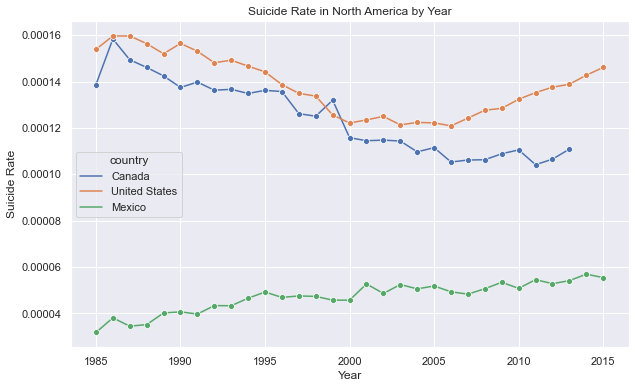

In [28]:
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(data=df_yr_ctr_na, x="year", y="sui_rate_yr", hue="country", marker='o',dashes=False,ci=None)

plt.xlabel("Year")
plt.ylabel("Suicide Rate")
plt.title('Suicide Rate in North America by Year')

In [29]:
df_USA = df_yr_ctr_na[df_yr_ctr_na['country'].isin (['United States'])]
df_USA = df_USA[['country','year','suicides_no_x','population_x']]
df_USA_yr = df_USA.groupby(by='year').sum()
df_USA_yr['suicide_rate'] =df_USA_yr['suicides_no_x']/df_USA_yr['population_x']
df_USA_yr.describe()

,suicides_no_x,population_x,suicide_rate
count,31.000000,3.100000e+01,31.000000
mean,33355.258065,2.598073e+08,0.000128
std,4305.852258,2.555165e+07,0.000009
min,29183.000000,2.207230e+08,0.000112
25%,30582.500000,2.368290e+08,0.000120
50%,31123.000000,2.622461e+08,0.000129
75%,35313.000000,2.815071e+08,0.000134
max,44189.000000,3.000785e+08,0.000147


In [30]:
df_Canada = df_yr_ctr_na[df_yr_ctr_na['country'].isin (['Canada'])]
df_Canada = df_Canada[['country','year','suicides_no_x','population_x']]
df_Canada_yr = df_Canada.groupby(by='year').sum()
df_Canada_yr['suicide_rate'] =df_Canada_yr['suicides_no_x']/df_Canada_yr['population_x']
df_Canada.describe()

,year,suicides_no_x,population_x
count,348.000000,348.000000,3.480000e+02
mean,1999.000000,309.083333,2.373713e+06
std,8.378647,326.117439,1.135684e+06
min,1985.000000,4.000000,3.902000e+05
25%,1992.000000,73.250000,1.920817e+06
50%,1999.000000,161.500000,2.181016e+06
75%,2006.000000,466.500000,2.523110e+06
max,2013.000000,1442.000000,5.088099e+06


In [31]:
df_Mexico = df_yr_ctr_na[df_yr_ctr_na['country'].isin (['Mexico'])]
df_Mexico = df_Mexico[['country','year','suicides_no_x','population_x']]
df_Mexico_yr = df_Mexico.groupby(by='year').sum()
df_Mexico_yr['suicide_rate'] =df_Mexico_yr['suicides_no_x']/df_Mexico_yr['population_x']
df_Mexico.describe()

,year,suicides_no_x,population_x
count,372.000000,372.000000,3.720000e+02
mean,2000.000000,298.760753,7.454191e+06
std,8.956318,347.943050,3.978867e+06
min,1985.000000,4.000000,4.320000e+05
25%,1992.000000,60.000000,4.041491e+06
50%,2000.000000,138.000000,8.711178e+06
75%,2008.000000,407.250000,1.051154e+07
max,2015.000000,1560.000000,1.594050e+07


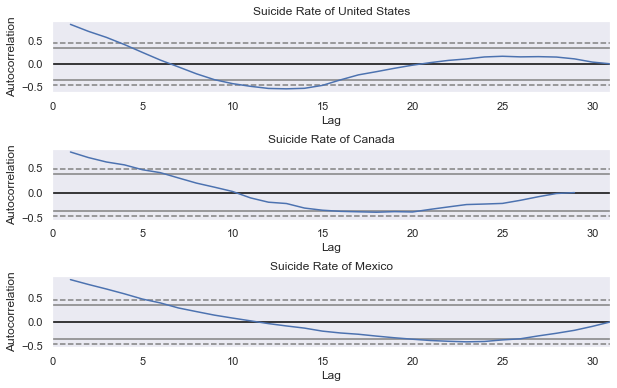

In [32]:
# plot autocorrelation for USA, Canada and Mexico
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

pd.plotting.autocorrelation_plot(df_USA_yr['suicide_rate'], ax = ax1)
pd.plotting.autocorrelation_plot(df_Canada_yr['suicide_rate'], ax = ax2)
pd.plotting.autocorrelation_plot(df_Mexico_yr['suicide_rate'], ax = ax3)


ax1.set_title('Suicide Rate of United States')
ax2.set_title('Suicide Rate of Canada')
ax3.set_title('Suicide Rate of Mexico')

ax1.set_xlim(0, max_lag)
ax2.set_xlim(0, max_lag)
ax3.set_xlim(0, max_lag)

fig.subplots_adjust(hspace = 0.8)
plt.show()

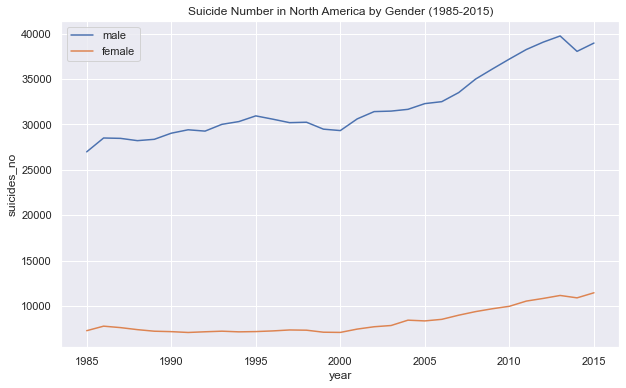

In [33]:
# Calculating the suicide number by gender in North America

# plot suicide number by gender in North America
df_men_na = df_year_country[df_year_country['country'].isin (['United States','Canada','Mexico'])]
df_men_na = df_men_na[df_men_na.sex == "male"]
df_men_na = df_men_na.groupby(by='year').sum()

df_women_na = df_year_country[df_year_country['country'].isin (['United States','Canada','Mexico'])]
df_women_na = df_women_na[df_women_na.sex == "female"]
df_women_na = df_women_na.groupby(by='year').sum()

sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(df_men_na.index, df_men_na.suicides_no, ci = None)
sns.lineplot(df_women_na.index, df_women_na.suicides_no, ci = None)
plt.title('Suicide Number in North America by Gender (1985-2015)')
plt.legend(["male", 'female'])
plt.show()

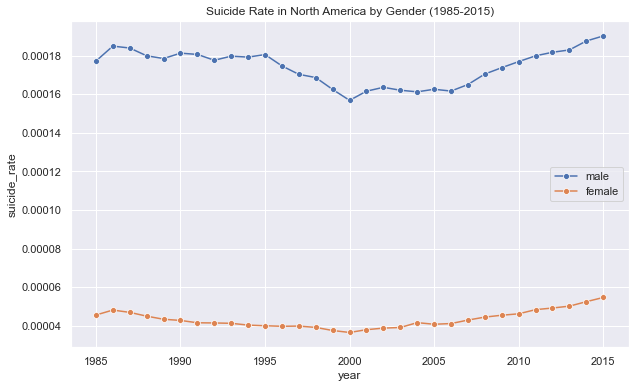

In [34]:
# Calculating the suicide rate by gender by year in North America

df_men_na['suicide_rate']=df_men_na['suicides_no']/df_men_na['population']
df_women_na['suicide_rate']=df_women_na['suicides_no']/df_women_na['population']

sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(df_men_na.index, df_men_na.suicide_rate,marker='o', ci = None)
sns.lineplot(df_women_na.index, df_women_na.suicide_rate,marker='o', ci = None)
plt.title('Suicide Rate in North America by Gender (1985-2015)')
plt.legend(["male", 'female'])
plt.show()

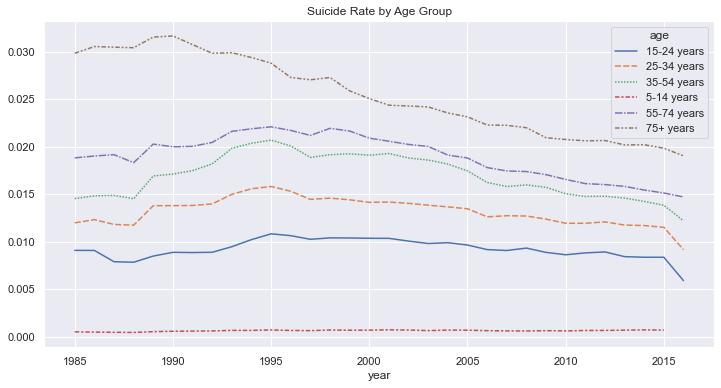

In [35]:
#Plotting the suicide rate by age
df_age = df.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "age",
             data = df_reset, style = "age")
#plt.xticks(rotation = 90)
plt.title('Suicide Rate by Age Group')
plt.show()

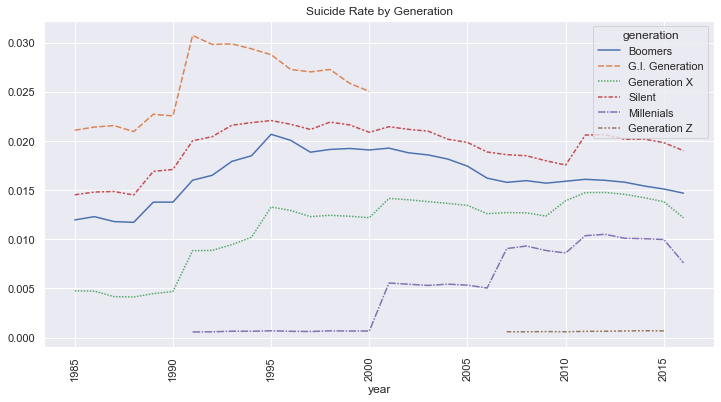

In [36]:
#Plotting the suicide rate by generation
df_generation = df.groupby(["year","generation"])["suicides_no", "population"].sum()
df_reset = df_generation.copy().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "generation",
             data = df_reset, style = "generation")
plt.xticks(rotation = 90)
plt.title('Suicide Rate by Generation')
plt.show()

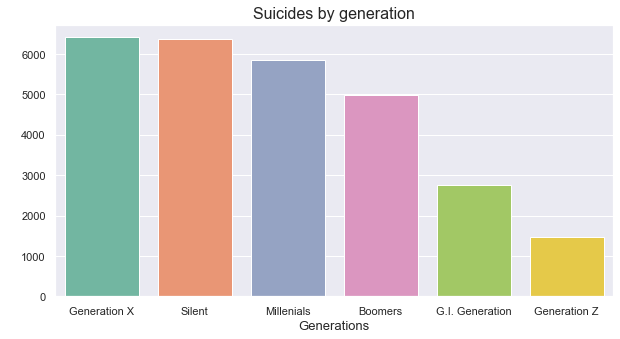

In [37]:
fig = plt.figure(figsize=(10,5))
sns.countplot('generation', order = df['generation'].value_counts().index, data = df, palette='Set2')
plt.xlabel('Generations', fontsize=13)
plt.ylabel(' ')
plt.title('Suicides by generation',fontsize=16);

In [38]:
Countries = ['Canada','United States','Mexico']
df_NA = df[df['country'].isin(Countries)].copy()
df_NA

,country,year,sex,age,suicides_no,population,suicides_100k_pop,gdp_for_year,gdp_per_capita,generation,continent
4916,Canada,1985,male,75+ years,111,390200,28.45,"364,756,499,451",15522,G.I. Generation,North America
4917,Canada,1985,male,55-74 years,502,1841000,27.27,"364,756,499,451",15522,G.I. Generation,North America
4918,Canada,1985,male,25-34 years,605,2240500,27.00,"364,756,499,451",15522,Boomers,North America
4919,Canada,1985,male,35-54 years,774,3046800,25.40,"364,756,499,451",15522,Silent,North America
4920,Canada,1985,male,15-24 years,560,2224600,25.17,"364,756,499,451",15522,Generation X,North America
...,...,...,...,...,...,...,...,...,...,...,...
27215,United States,2015,female,25-34 years,1444,21555712,6.70,"18,120,714,000,000",60387,Millenials,North America
27216,United States,2015,female,15-24 years,1132,21633813,5.23,"18,120,714,000,000",60387,Millenials,North America
27217,United States,2015,female,75+ years,540,11778666,4.58,"18,120,714,000,000",60387,Silent,North America
27218,United States,2015,male,5-14 years,255,21273987,1.20,"18,120,714,000,000",60387,Generation Z,North America


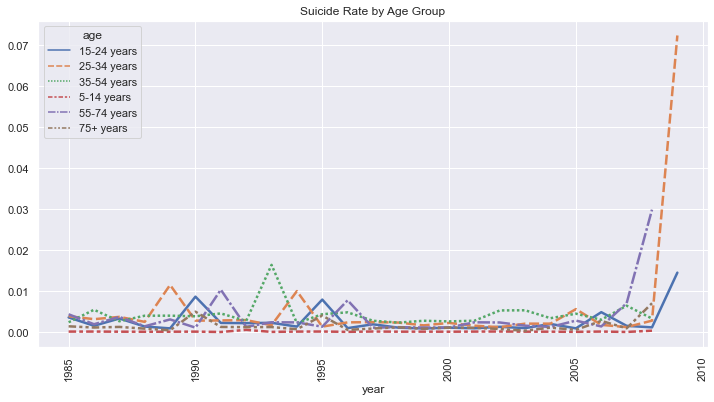

In [39]:
df_age_NA = df_NA.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset_NA = df_age_NA.copy().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot("year", df_reset_NA.suicides_no*100/df_reset.population, hue = "age",
             data = df_reset_NA, linewidth = 2.5, style = "age")
plt.xticks(rotation = 90)
plt.title('Suicide Rate by Age Group')
plt.show()

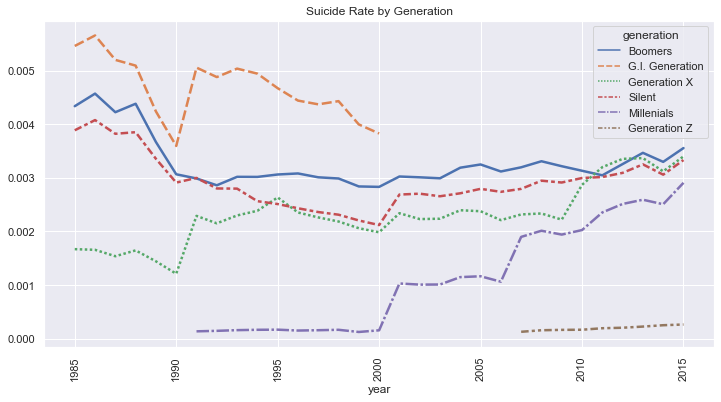

In [40]:
df_generation_NA = df_NA.groupby(["year","generation"])["suicides_no", "population"].sum()
df_reset_NA = df_generation_NA.copy().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot("year", df_reset_NA.suicides_no*100/df_reset.population, hue = "generation",
             data = df_reset_NA, linewidth = 2.5, style = "generation")
plt.xticks(rotation = 90)
plt.title('Suicide Rate by Generation')
plt.show()

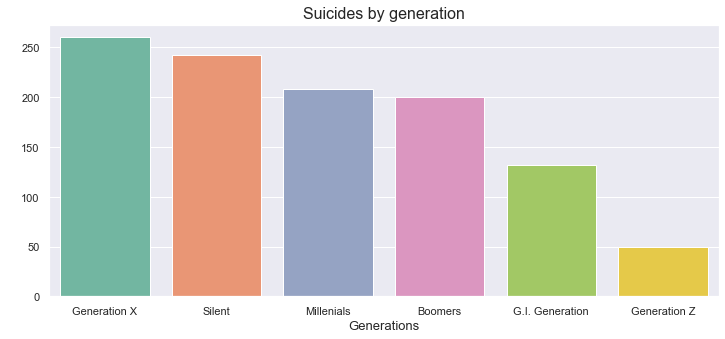

In [41]:
fig = plt.figure(figsize=(12,5))
sns.countplot('generation', order = df_NA['generation'].value_counts().index, data = df_NA, palette = 'Set2')
plt.xlabel('Generations', fontsize=13)
plt.ylabel(' ')
plt.title('Suicides by generation',fontsize=16);

<AxesSubplot:xlabel='population', ylabel='suicides_no'>

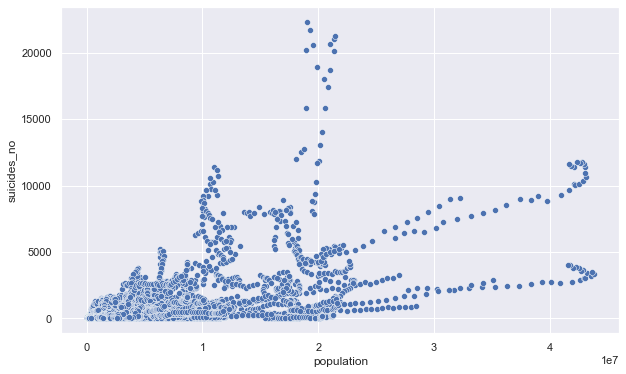

In [42]:
sns.scatterplot(x='population', y='suicides_no', data=df)

In [43]:
df_pop = df.groupby(('country'))[['population','suicides_no']].mean().sort_values(by='population', ascending=False)
df_pop

,population,suicides_no
country,,
United States,2.165061e+07,2779.604839
Brazil,1.305401e+07,609.174731
Russian Federation,1.139137e+07,3733.771605
Japan,9.895228e+06,2169.091398
Mexico,7.454191e+06,298.760753
...,...,...
Antigua and Barbuda,6.142679e+03,0.033951
Kiribati,5.618227e+03,0.401515
Dominica,5.533333e+03,0.000000


In [44]:
df_pop.corr()

,population,suicides_no
population,1.000000,0.812873
suicides_no,0.812873,1.000000


Text(0.5, 1.0, 'Population vs. Suicide No')

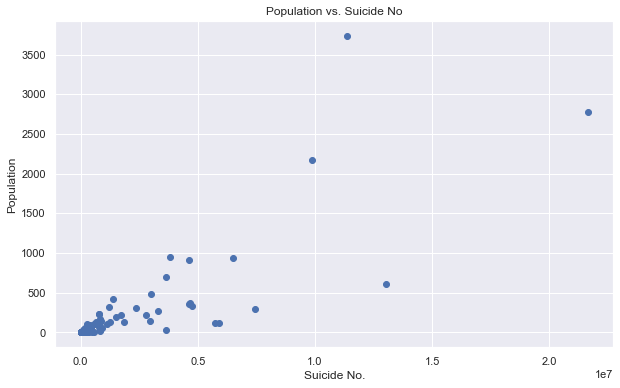

In [45]:
plt.scatter(df_pop['population'], df_pop['suicides_no'])
plt.xlabel('Suicide No.')
plt.ylabel('Population')
plt.title('Population vs. Suicide No')


There definitley seems to be a high positive correlation with population and suicide_no. In countries where the overall population is high, the suicide rate is also high. 

Text(0.5, 1.0, 'Population vs. Suicides No.')

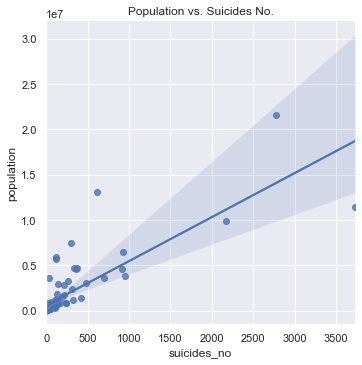

In [46]:
sns.lmplot(x='suicides_no', y='population', data=df_pop)
plt.title('Population vs. Suicides No.')

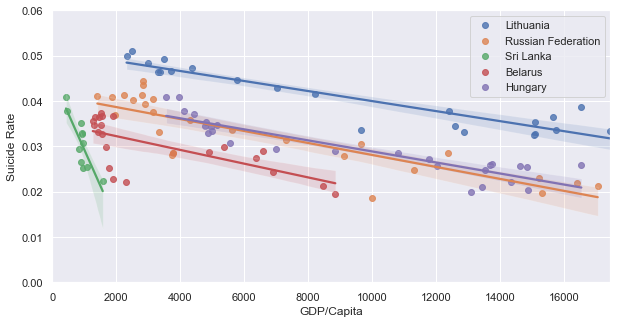

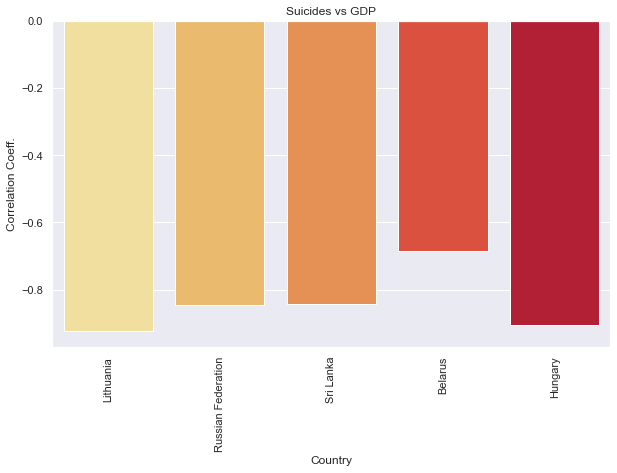

In [53]:
df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()

country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

plt.figure(figsize = (10,5))
for country in country_list[:5]:
    sns.regplot(x=df_gdp[country].values, y=df_total[country].values, label = country)
plt.xlabel("GDP/Capita")
plt.ylabel("Suicide Rate")
plt.ylim(0,0.06)
plt.xlim(0)
plt.legend()
plt.show()

corr_eff = {}
for country in country_list[:5]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Correlation Coeff.")
plt.title("Suicides vs GDP")
plt.show()

In [49]:
# As above charts shows, for the top 10 countries with highest GDP/Capita, there a strong nagative relationship between suicide rate and GDP/Capta
# Let's see the 3 countries in North America
print("index number of Canada is", country_list.index('Canada'))
print("index number of the United States is", country_list.index('United States'))
print("index number of Mexico is", country_list.index('Mexico'))

index number of Canada is 34
index number of the United States is 37
index number of Mexico is 76


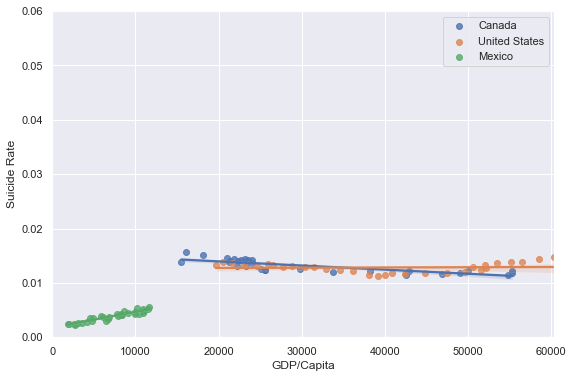

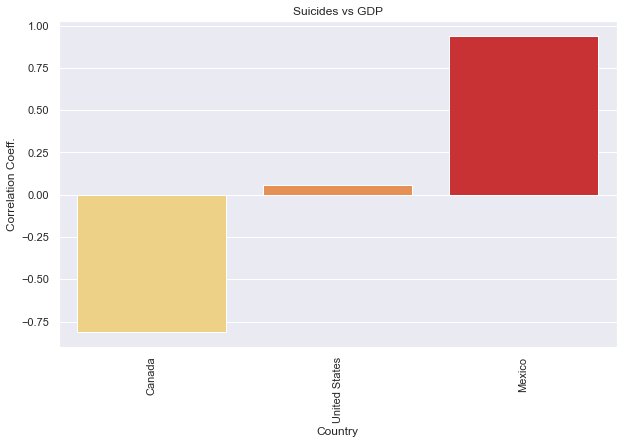

In [54]:
plt.figure(figsize = (9,6))
for country in [country_list[34], country_list[37], country_list[76]]:
    sns.regplot(x=df_gdp[country].values, y=df_total[country].values, label = country)
plt.xlabel("GDP/Capita")
plt.ylabel("Suicide Rate")
plt.ylim(0,0.06)
plt.xlim(0)
plt.legend()
plt.show()

corr_eff = {}
for country in [country_list[34], country_list[37], country_list[76]]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Correlation Coeff.")
plt.title("Suicides vs GDP")
plt.show()

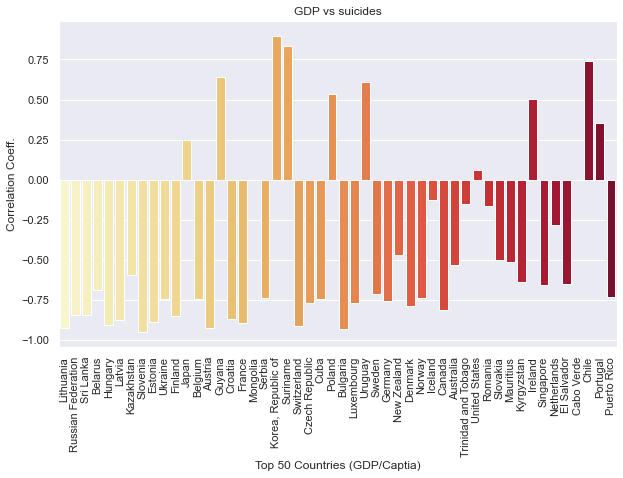

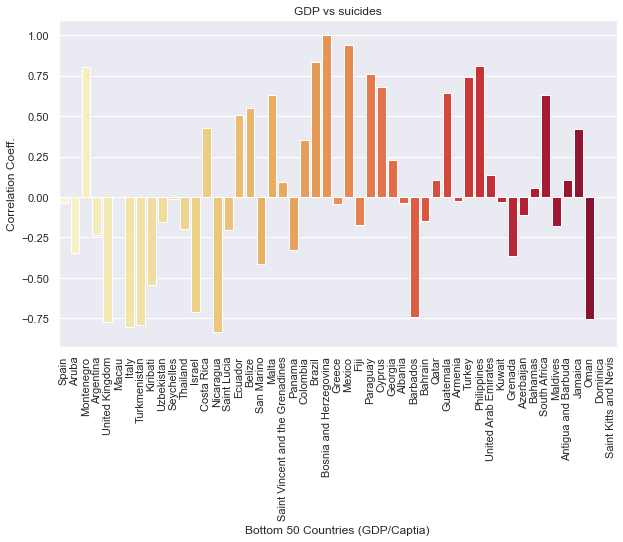

In [55]:
# In North America, Canada shows a negative relationship between the two factors, while the US shows little relationship. However, Maxico has a positive relationship between suicide rate and GDP/capita. 
# A notable point is that the gdp per capita of Mexico mainly lies under 10000, while the data of Canada and USA mostly are between 20000 and 60000.
# Let's see the overview of all countries (top 50 vs. bottom 50)
corr_eff = {}
for country in country_list[:50]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Top 50 Countries (GDP/Captia)")
plt.ylabel("Correlation Coeff.")
plt.title("GDP vs suicides")
plt.show()

corr_eff = {}
for country in country_list[50:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Bottom 50 Countries (GDP/Captia)")
plt.ylabel("Correlation Coeff.")
plt.title("GDP vs suicides")
plt.show()

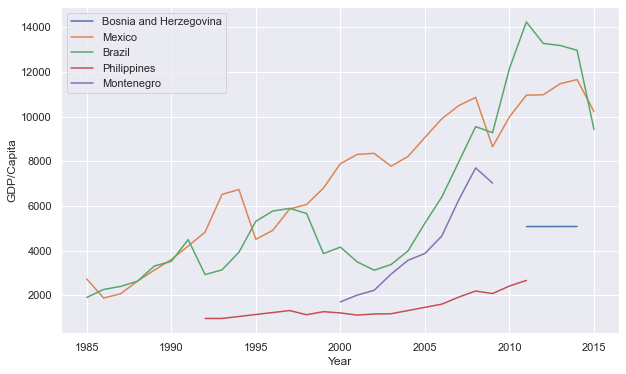

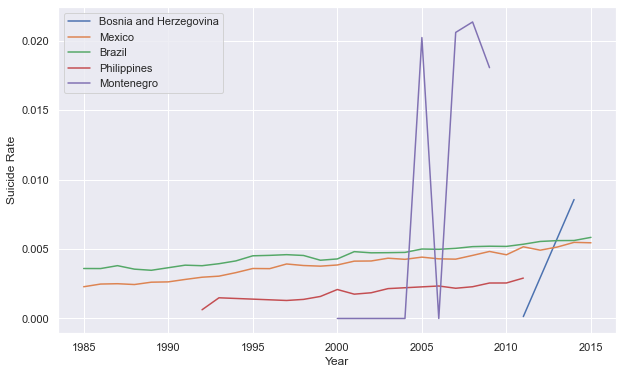

In [56]:
#let's see the top 5 countries with strong positive relationship

positive_relation_gdp = {a:b for a,b in corr_eff.items() if b > 0.6}
positive_relation_tup = list(positive_relation_gdp.items())
positive_relation_tup.sort(key= lambda pair:pair[1], reverse = True)
positive_relation = {a[0]:a[1] for a in positive_relation_tup}

city_list = list({a:b for a,b in positive_relation.items()})
for country in city_list[:5]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country)
plt.xlabel("Year")
plt.ylabel("GDP/Capita")
plt.legend()
plt.show()

for country in city_list[:5]:
    plt.plot(df_total[country].index,df_total[country].values, label=country)
plt.xlabel("Year")
plt.ylabel("Suicide Rate")
plt.legend()
plt.show()

In [ ]:
#Among these 5 countries, the Republic of Korea is a notable one. The GDP/Capita of remaining countries are mostly under 15000 over the decades, but South Korea almost doubled in 2015. In contrast to the result of section a, the suicide rate of this country increases as GDP grows, which can be assumed that other reasons, like social norms and peer pressure in East Asian culture, also contribute to suicide rate besides GDP

### Main Conclusions:

- The ratio of suicides decreases as gdp per capita increases among the 10 countries with highest GDP/capita. There is a strong negative relationship between ratio of suicide and gdp per capita among the 10 richeset countries in which 9 European countries involved.
- European countries over represented the high suicides in the world due to changes in the social system and economic shock during the transition process.
- Males have higher suicide rate than females. Males are three times more likely to die by suicide in the world, while four times in North America.
- According to the suicide rate of each age group, the suicide rate is getting higher when the age is higher. The elderly should be cared for more than young people. In addition, the country welfare of the elderly may also impact the rate.
- Gen X and silent generations have had the maximum number of suicides. Gen X and silent generations have had the maximum number of suicides. Whereas G.I. generation, and Silent have had the highest rate of suicide in the world.
- There is a peak suicide rate in 1995, seems goes up from 2016, but no data to support more about this trend because of the limitation of dataset.

### Next Steps:

Taking the suicides data which was captured from 1985 to 2016 among 101 countries in the world, I analyzed the relationships between suicides and several signals. The suicides are affected by many factors, such as age, gender, and gdp. With the high speed of socio-economic growth over the last 30 years, a fast-paced lifestyle, high social pressure becomes common in people’s daily life. Suicides have become a social issue nowadays.

The government should take more care on citizen’s health care, especially for elderly. Mental health should be aware to everyone to prevent it in the early stage before suicides occur. The social societies should pay
attention to people’s improvement of life skills including problem solving skills and coping skills, ability to adapt to change.

In addition, other factors may affect suicides such as the social transition, economic shock, civil war and culture. Our purpose is not only to focus on reducing suicides simply but also building a better society.